In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ModuleNotFoundError: No module named 'pandas'

In [ ]:
import torch 
import timm
from torch.utils.data import DataLoader,random_split
from torchvision import transforms as ts
import torch.nn.functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Dataset root
train_path ='/kaggle/input/vietnamese-foods/Images/Train'
valid_path = '/kaggle/input/vietnamese-foods/Images/Validate'
test_path = '/kaggle/input/vietnamese-foods/Images/Test'

In [ ]:
# Transforming the data
trf = ts.Compose([ts.Resize((64,64)),
                    ts.ToTensor(),
                    ts.Normalize(0.5, 0.5)])

In [ ]:
# Loading the dataset
def load_data(train, test, valid):
    
    train = datasets.ImageFolder(root=train_path, transform=trf)
    test = datasets.ImageFolder(root=test_path, transform=trf)
    valid = datasets.ImageFolder(root=valid_path, transform=trf)
    
    
    print(f'Train dataset: {len(train)}')
    print(f'Validation dataset: {len(valid)}')
    print(f'Test dataset: {len(test)}')
    print(f'Number of classes: {len(train.classes)}')
          
    return train, test, valid  

train_dataset, val_dataset, test_dataset = load_data(train_path,test_path,valid_path)

Train dataset: 17581
Validation dataset: 2515
Test dataset: 5040
Number of classes: 30


In [ ]:
# Splitting the data into batches
bs=128
train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=bs, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=bs, shuffle=False)

print(len(train_dl))
print(len(val_dl))
print(len(test_dl))

138
40
20


In [ ]:
timm.list_models('resnet152*')

['resnet152', 'resnet152d']

In [ ]:
resnet = timm.create_model(model_name='resnet152',pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet152_a1h-dc400468.pth" to /root/.cache/torch/hub/checkpoints/resnet152_a1h-dc400468.pth


In [ ]:
#resnet.eval()
torch.cuda.empty_cache()

In [ ]:
def train_setup(resnet): 
    return resnet.to("cuda"), 20, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = resnet.parameters(), lr = 0.001)

resnet, epochs, device, loss_fn, optimizer = train_setup(resnet)

In [ ]:
if torch.cuda.is_available():
    print('GPU is available')
    device = torch.device('cuda:0')
    print(f'Total GPU memory: {torch.cuda.get_device_properties(device).total_memory / 1024 ** 2:.2f} MB')
    print(f'Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB')
    print(f'Free GPU memory: {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB')
else:
    print('GPU is not available')

GPU is available
Total GPU memory: 16280.88 MB
Allocated GPU memory: 230.28 MB
Free GPU memory: 244.00 MB


In [ ]:
from torch.cuda.amp import autocast, GradScaler

In [ ]:
patience = 4  # stop training if validation loss does not improve for 3 epochs
best_val_loss = float('inf')
best_val_acc = 0
improvement = 0

train_losses, train_accs = [], []
val_losses, val_accs = [], []

scaler = GradScaler()

for epoch in range(epochs):
    
    epoch_loss, epoch_acc, total = 0, 0, 0
    for idx, batch in tqdm(enumerate(train_dl)):
        ims, gts = batch
        ims, gts = ims.to(device), gts.to(device)
        
        total += ims.shape[0]
        
        with autocast():
            preds = resnet(ims)
            loss = loss_fn(preds, gts)
        
        scaler.scale(loss).backward()
        
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
        _, pred_cls = torch.max(preds.data, dim = 1)
        epoch_acc += (pred_cls == gts).sum().item()
        epoch_loss += loss.item()
        
    
    tr_loss = epoch_loss / len(train_dl)
    train_losses.append(tr_loss)
    train_accs.append(epoch_acc/total)
    
    print(f"Epoch {epoch + 1} train process is finished")
    print(f"Epoch {epoch + 1} train loss -> {(tr_loss):.3f}")
    print(f"Epoch {epoch + 1} train accuracy -> {(epoch_acc / total):.3f}")
    
    resnet.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_total = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)
            val_total += ims.shape[0]

            with autocast():
                preds = resnet(ims)
                loss = loss_fn(preds, gts)

            _, pred_cls = torch.max(preds.data, dim = 1)
            val_epoch_acc += (pred_cls == gts).sum().item()
            val_epoch_loss += loss.item()
        
        val_acc = val_epoch_acc / val_total
        val_loss = val_epoch_loss / len(val_dl)
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch + 1} validation is finished")
        print(f"Epoch {epoch + 1} validation loss -> {(val_loss):.3f}")
        print(f"Epoch {epoch + 1}  validation accuracy -> {val_acc:.3f}")
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            improvement = 0
            #torch.save(resnet.state_dict(), 'resnet_model.pth')
        else:
            improvement += 1
            if improvement >= patience:
                print(f"No improvement in validation loss for {patience} epochs. Stopping early.")
                break


138it [06:32,  2.85s/it]


Epoch 1 train process is finished
Epoch 1 train loss -> 3.587
Epoch 1 train accuracy -> 0.170
Epoch 1 validation is finished
Epoch 1 validation loss -> 2.328
Epoch 1  validation accuracy -> 0.345


138it [05:18,  2.31s/it]


Epoch 2 train process is finished
Epoch 2 train loss -> 2.365
Epoch 2 train accuracy -> 0.321
Epoch 2 validation is finished
Epoch 2 validation loss -> 2.011
Epoch 2  validation accuracy -> 0.421


138it [05:12,  2.26s/it]


Epoch 3 train process is finished
Epoch 3 train loss -> 1.669
Epoch 3 train accuracy -> 0.501
Epoch 3 validation is finished
Epoch 3 validation loss -> 1.780
Epoch 3  validation accuracy -> 0.475


138it [05:13,  2.27s/it]


Epoch 4 train process is finished
Epoch 4 train loss -> 1.349
Epoch 4 train accuracy -> 0.590
Epoch 4 validation is finished
Epoch 4 validation loss -> 1.608
Epoch 4  validation accuracy -> 0.528


138it [05:16,  2.29s/it]


Epoch 5 train process is finished
Epoch 5 train loss -> 1.071
Epoch 5 train accuracy -> 0.668
Epoch 5 validation is finished
Epoch 5 validation loss -> 1.601
Epoch 5  validation accuracy -> 0.532


138it [05:15,  2.29s/it]


Epoch 6 train process is finished
Epoch 6 train loss -> 0.870
Epoch 6 train accuracy -> 0.726
Epoch 6 validation is finished
Epoch 6 validation loss -> 1.612
Epoch 6  validation accuracy -> 0.544


138it [05:08,  2.23s/it]


Epoch 7 train process is finished
Epoch 7 train loss -> 0.630
Epoch 7 train accuracy -> 0.798
Epoch 7 validation is finished
Epoch 7 validation loss -> 1.883
Epoch 7  validation accuracy -> 0.515


138it [05:08,  2.24s/it]


Epoch 8 train process is finished
Epoch 8 train loss -> 0.479
Epoch 8 train accuracy -> 0.846
Epoch 8 validation is finished
Epoch 8 validation loss -> 1.755
Epoch 8  validation accuracy -> 0.549


138it [05:28,  2.38s/it]


Epoch 9 train process is finished
Epoch 9 train loss -> 0.365
Epoch 9 train accuracy -> 0.879
Epoch 9 validation is finished
Epoch 9 validation loss -> 1.920
Epoch 9  validation accuracy -> 0.571
No improvement in validation loss for 4 epochs. Stopping early.


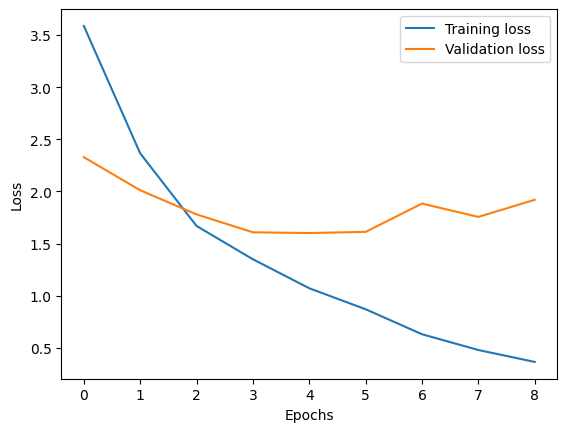

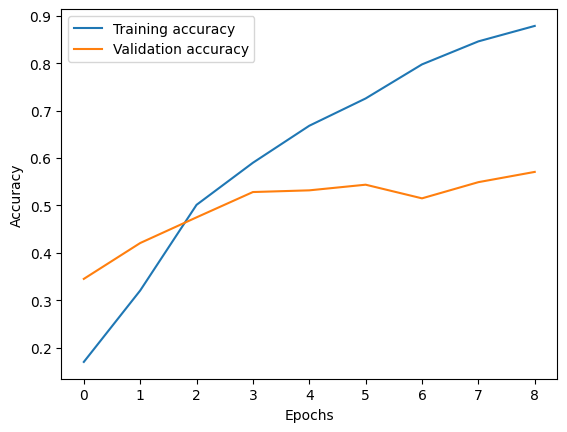

In [ ]:

# plot the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
ims, gts = next(iter(test_dl))

preds, images, lbls = [], [], []
for im, gt in zip(ims, gts):
    im, gt = im.to(device), gt.to(device)
    _, pred = torch.max(resnet(im.unsqueeze(0)), dim = 1)
    images.append(im)
    preds.append(pred.item())
    lbls.append(gt)
print(len(preds))   

128


In [ ]:
def tensor_2_im(t): return (t * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

In [ ]:
import pandas as pd
import numpy as np


classnames = train_dataset.classes
classnames

['Banh beo',
 'Banh bot loc',
 'Banh can',
 'Banh canh',
 'Banh chung',
 'Banh cuon',
 'Banh duc',
 'Banh gio',
 'Banh khot',
 'Banh mi',
 'Banh pia',
 'Banh tet',
 'Banh trang nuong',
 'Banh xeo',
 'Bun bo Hue',
 'Bun dau mam tom',
 'Bun mam',
 'Bun rieu',
 'Bun thit nuong',
 'Ca kho to',
 'Canh chua',
 'Cao lau',
 'Chao long',
 'Com tam',
 'Goi cuon',
 'Hu tieu',
 'Mi quang',
 'Nem chua',
 'Pho',
 'Xoi xeo']

In [ ]:
import random

invTrans = ts.Compose([ ts.Normalize(mean = [ 0. ], std = [ 1/0.5]), ts.Normalize(mean = [ -0.5 ], std = [ 1. ])  ])


def visualize_test(ims, num_ims, row):
    
    plt.figure(figsize = (30, 20))
    indexes = [random.randint(0, len(ims) - 1) for _ in range(num_ims)]
    for idx, indeks in enumerate(indexes):
        
        im = ims[indeks]
        gt = lbls[indeks]
        pred = preds[indeks]
        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(invTrans(im)), cmap='gray')
        plt.axis('off')
        plt.title(f"GT -> {classnames[gt]} ; Prediction -> {classnames[pred]}")

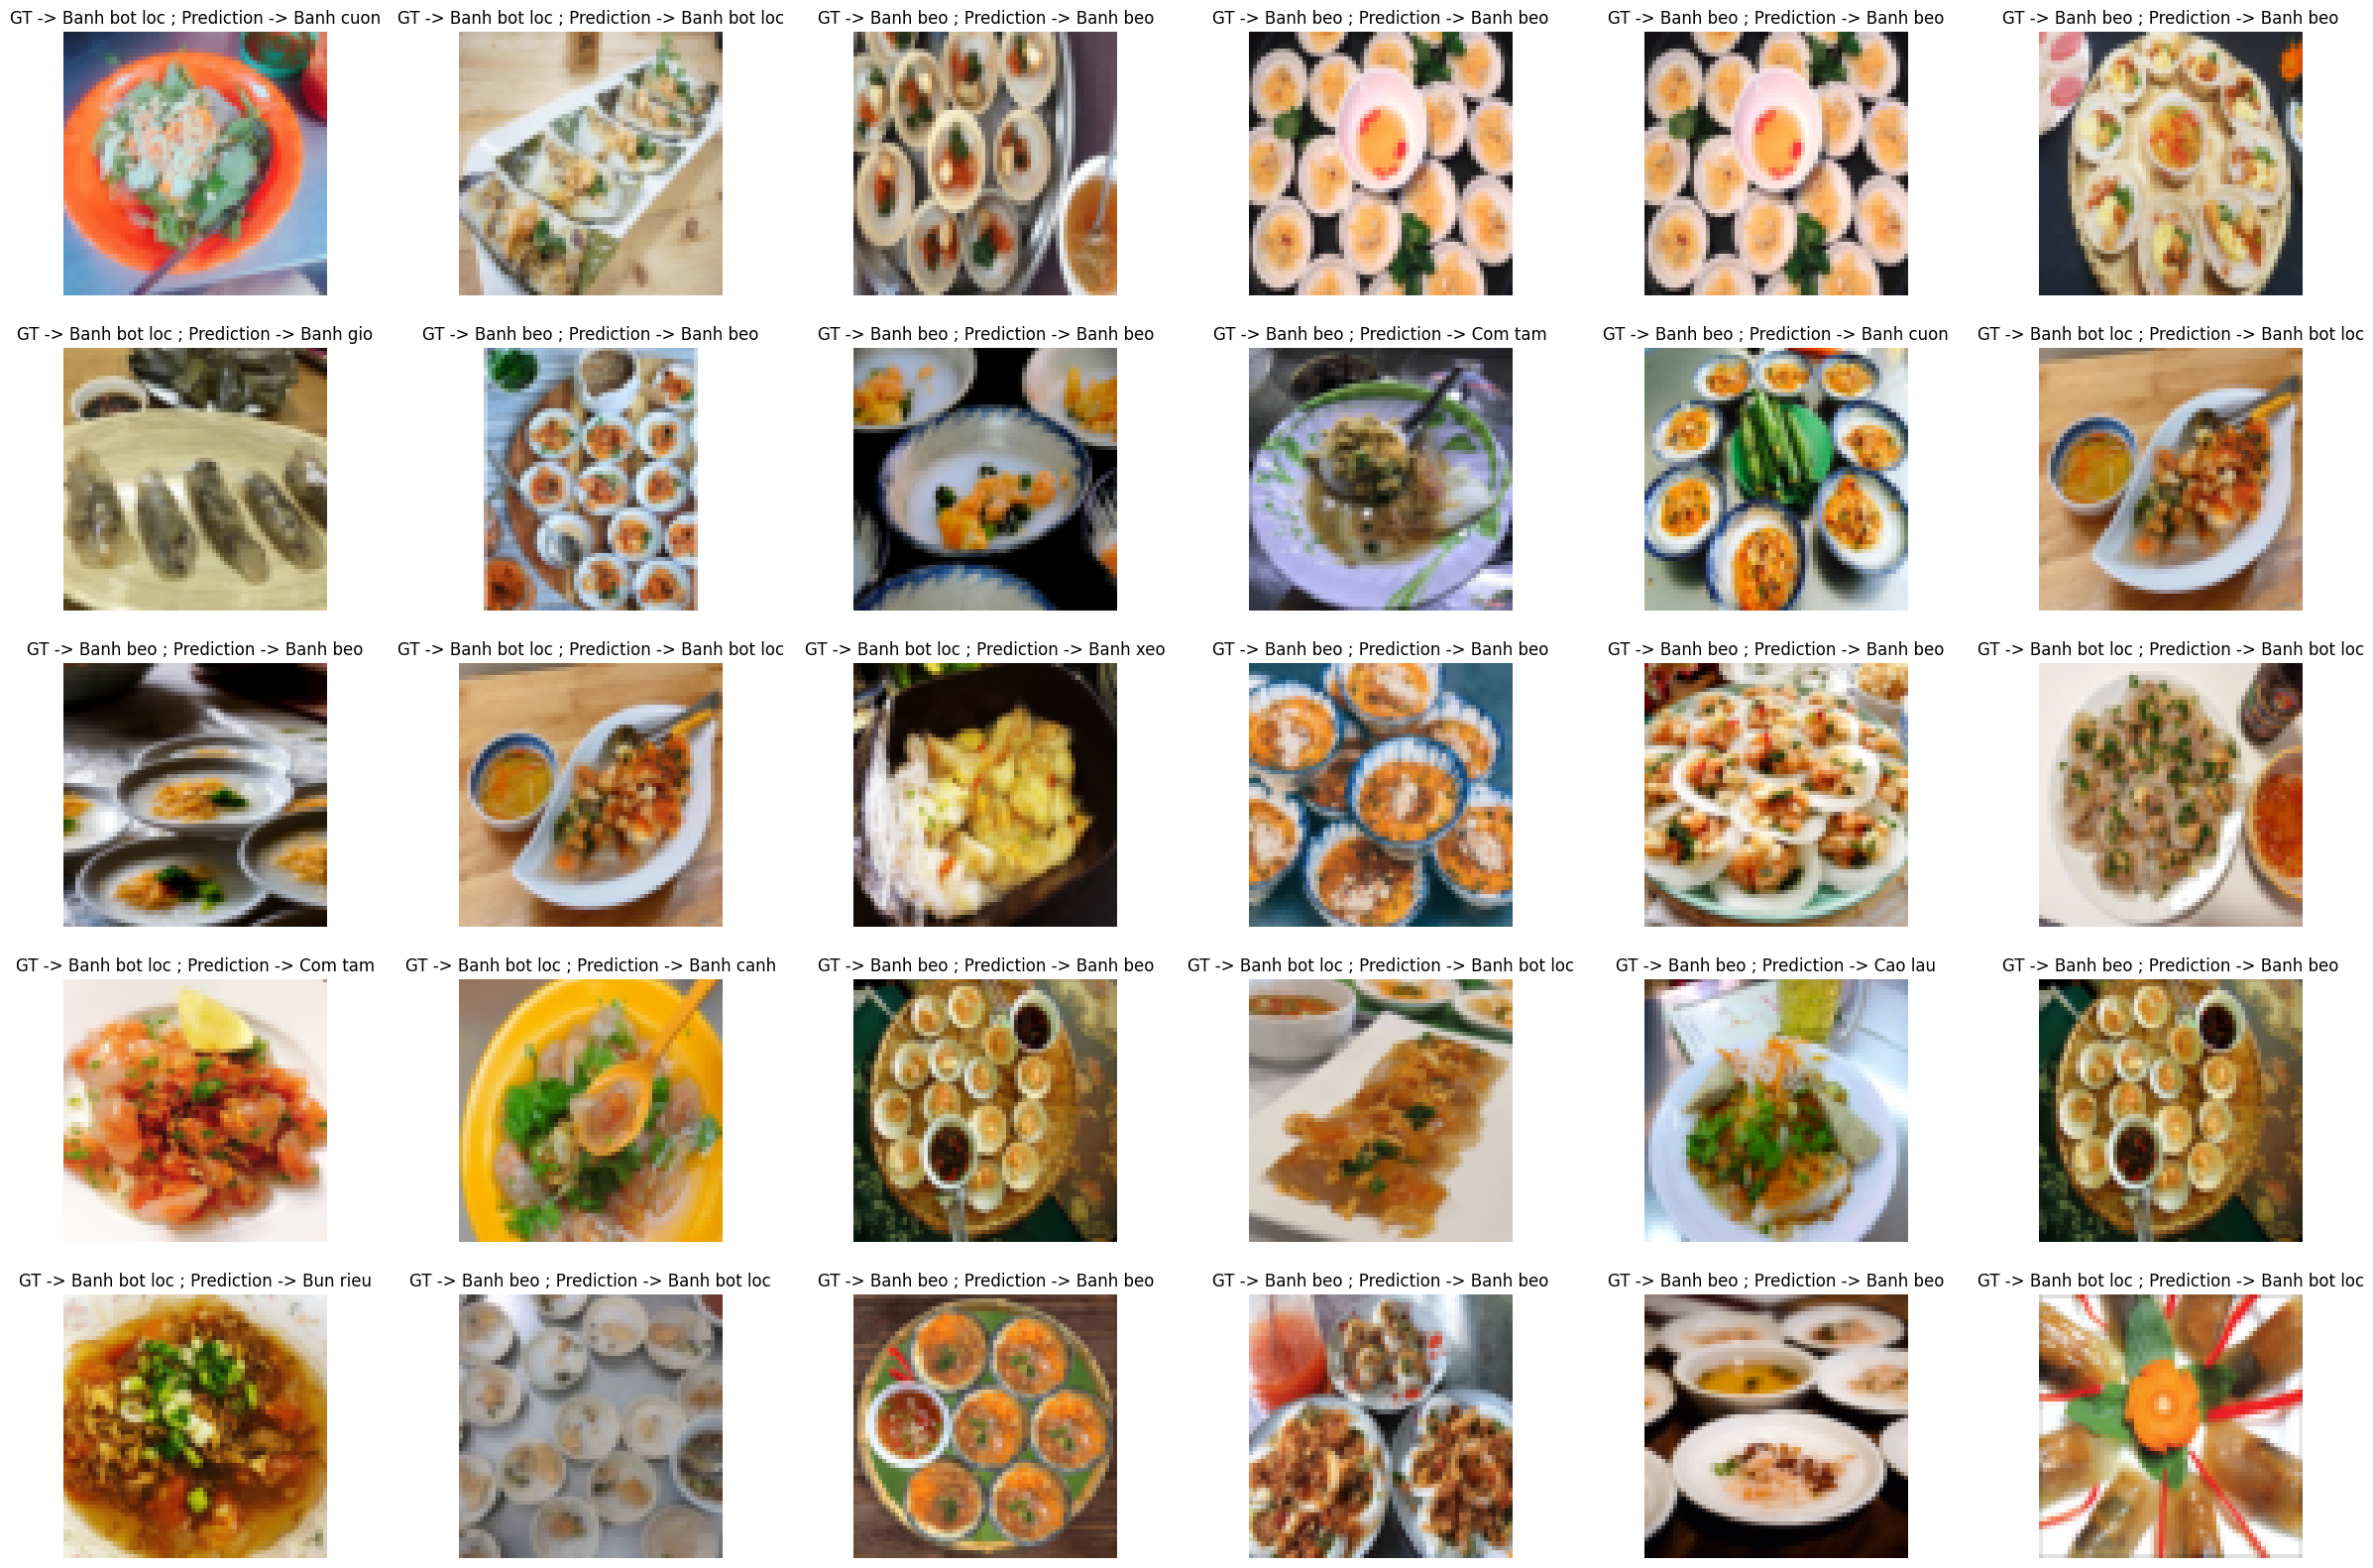

In [ ]:
visualize_test(ims, 30, 5)